In [1]:
# hide
# all_slow

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Raster Zonal Stats Tutorial

> A basic introduction to Raster Zonal Stats 

## Basic Usage

Generate zonal stats for a GeoDataframe containing areas of interest using raster data

Terms:

* **aoi** - (area of interest) a geodataframe which we are interested in generating zonal statistics for
* **raster data** - the source raster containing the features which we are interested in collecting zonal stats for our aoi.


In [5]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/region34ncr_admin.geojson ] && curl -s -o ../data/region34ncr_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region34ncr_admin.geojson
![ ! -e ../data/region3_admin_grids.geojson ] && curl -s -o ../data/region3_admin_grids.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin_grids.geojson
![ ! -e ../data/region3_bingtile_grid13.geojson ] && curl -s -o ../data/region3_bingtile_grid13.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_bingtile_grid13.geojson

In [6]:
# hide
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geowrangler.raster_zonal_stats as rzs

### Load AOI

Our areas of interest (AOI)  are three (3)  Level 1 administration regions (ADM1) of the Philippines located in the island of Luzon.

In [8]:
%%time
# area multipolygons for regions 3,4,ncr of the philippines
aoi = gpd.read_file("../data/region34ncr_admin.geojson")

CPU times: user 3.26 s, sys: 195 ms, total: 3.45 s
Wall time: 3.44 s


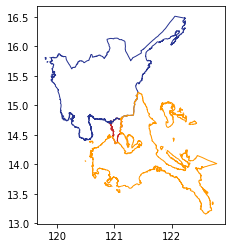

In [9]:
# no_test
ax = aoi.plot(
    ax=plt.axes(),
    facecolor="none",
    edgecolor=[
        "#C62828",
        "#283593",
        "#FF9800",
    ],
)

In [10]:
# no_test
aoi

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ..."
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ..."


### Download Philippine Population Data
> see the [Humanitarian Data Exchange World Population Counts - Philippines](https://data.humdata.org/dataset/worldpop-population-counts-for-philippines)

We download our raster Data as GeoTiff files from the Humanitarian Data Exchange site.

> Note: This maybe slow as the file is about 180 Mb and depending on your internet download speed may take more than 5 minutes

In [11]:
# PHL population HDX links
phil_pop_link = "https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/PHL/phl_ppp_2020.tif"
phil_pop_dset = "phl_pop_2020.tif"

In [12]:
%%time

![ ! -e ../data/{phil_pop_dset} ] && curl -o ../data/{phil_pop_dset} {phil_pop_link}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  180M  100  180M    0     0   576k      0  0:05:19  0:05:19 --:--:--  430k
CPU times: user 12 s, sys: 3.57 s, total: 15.6 s
Wall time: 5min 19s


To create our raster zonal stats, we just need to 
set the aggregations, as well as some extra arguments,
such as the `nodata` value in the raster.

In [13]:
%%time
results = rzs.create_raster_zonal_stats(
    aoi,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        column="population",
        output=["population_count", "samples"],
    ),
    extra_args=dict(nodata=-99999),  # nodata value is -99999
)

CPU times: user 4.22 s, sys: 128 ms, total: 4.35 s
Wall time: 4.34 s


In [14]:
results

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,samples,population_count
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ...",70786,13165866.0
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",2558377,11493727.0
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ...",1876244,15952383.0


### Using Grid Tile AOIs

We can also use tile grids as our AOIs.


In [15]:
# note that you don't need to load the aoi first
grid_aoi_file = "../data/region3_admin_grids.geojson"

In [16]:
%%time
grid_aoi_results = rzs.create_raster_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        column="population",
        output=["population_count", "samples"],
        fillna=[True, True],
    ),
    extra_args=dict(nodata=-99999),  # nodata value is -99999
)

CPU times: user 8.57 s, sys: 12.2 ms, total: 8.59 s
Wall time: 8.58 s


In [17]:
grid_aoi_results.head()

,x,y,geometry,samples,population_count
0,0,30,"POLYGON ((119.78583 15.70870, 119.83075 15.708...",171,1171.764038
1,0,31,"POLYGON ((119.78583 15.75193, 119.83075 15.751...",329,278.567200
2,0,32,"POLYGON ((119.78583 15.79516, 119.83075 15.795...",345,279.140198
3,1,30,"POLYGON ((119.83075 15.70870, 119.87566 15.708...",158,808.681152
4,1,32,"POLYGON ((119.83075 15.79516, 119.87566 15.795...",20,0.000000


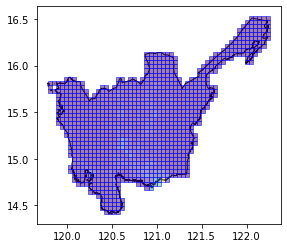

In [18]:
# no_test
ax = aoi[aoi.Reg_Name == "Region III"].plot(
    ax=plt.axes(), facecolor="none", edgecolor="black"
)
ax = grid_aoi_results.plot(
    ax=ax, column="population_count", edgecolor="blue", alpha=0.5
)

### Using Bing Tile Grid Tile AOIs

We can also use pre-existing Bing tile grids as our AOIs.


In [19]:
# note that you don't need to load the aoi first
bingtile_grid_aoi_file = "../data/region3_bingtile_grid13.geojson"

In [20]:
%%time
bingtile_grid_aoi_results = rzs.create_raster_zonal_stats(
    bingtile_grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        column="population",
        output=["population_count", "samples"],
        fillna=[True, True],
    ),
    extra_args=dict(nodata=-99999),  # nodata value is -99999
)

CPU times: user 10.6 s, sys: 124 ms, total: 10.7 s
Wall time: 10.7 s


In [21]:
bingtile_grid_aoi_results.head()

,quadkey,geometry,samples,population_count
0,1323030303301,"POLYGON ((120.10254 14.73239, 120.10254 14.774...",737,196.756744
1,1323030303300,"POLYGON ((120.05859 14.73239, 120.05859 14.774...",50,35.732861
2,1323030303311,"POLYGON ((120.19043 14.73239, 120.19043 14.774...",248,383.338013
3,1323030303133,"POLYGON ((120.19043 14.77488, 120.19043 14.817...",901,5621.879395
4,1323030303131,"POLYGON ((120.19043 14.81737, 120.19043 14.859...",1328,6584.988770


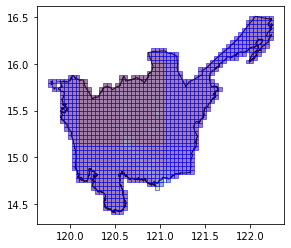

In [22]:
# no_test
ax = aoi[aoi.Reg_Name == "Region III"].plot(
    ax=plt.axes(), facecolor="none", edgecolor="black"
)
ax = bingtile_grid_aoi_results.plot(
    ax=ax, column="population_count", edgecolor="blue", alpha=0.5
)